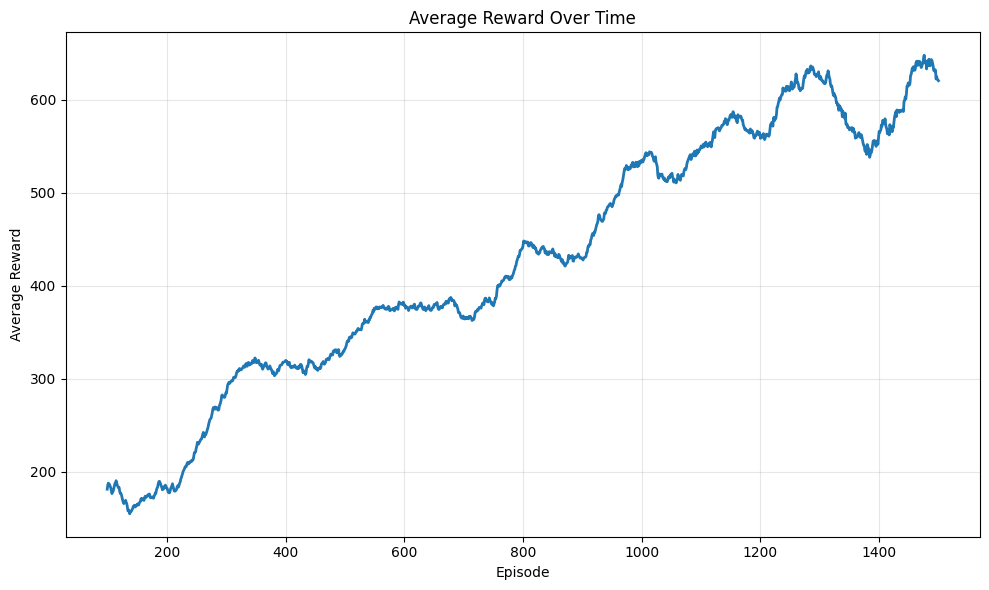

In [2]:
import re
import matplotlib.pyplot as plt

# Read the file
with open('../logs/rew/avg_reward_norm.txt', 'r') as f:
    lines = f.readlines()

# Parse episodes and rewards
episodes = []
rewards = []

for line in lines:
    match = re.search(r'Episode (\d+); Average Reward: ([\d.]+)', line)
    if match:
        episodes.append(int(match.group(1)))
        rewards.append(float(match.group(2)))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(episodes, rewards, linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward Over Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

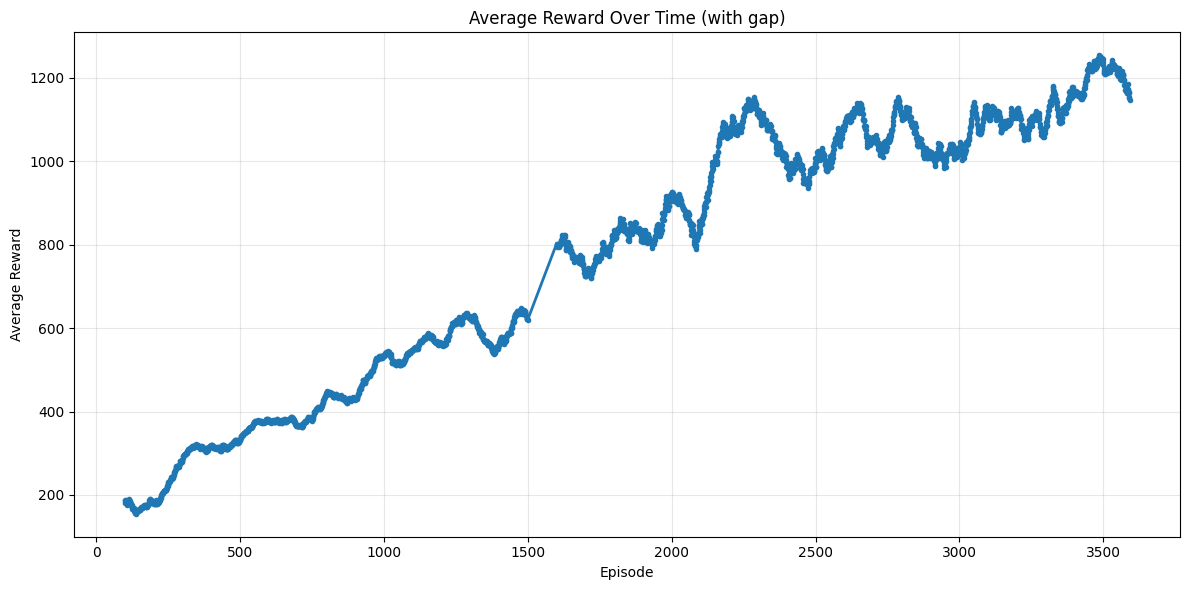

In [ ]:
import re
import matplotlib.pyplot as plt

def read_and_parse(filename):
    """Read file and parse episodes and rewards"""
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    episodes = []
    rewards = []
    
    for line in lines:
        match = re.search(r'Episode (\d+); Average Reward: ([\d.]+)', line)
        if match:
            episodes.append(int(match.group(1)))
            rewards.append(float(match.group(2)))
    
    return episodes, rewards

# Read both files
episodes1, rewards1 = read_and_parse('../logs/rew/avg_reward_norm.txt')
episodes2, rewards2 = read_and_parse('../logs/rew/avg_reward_norm_2.txt')  # Change filename

# Offset second file episodes: add 1501 to shift them to 1600-3501
episodes2_offset = [ep + 1501 for ep in episodes2]

# Combine the data
all_episodes = episodes1 + episodes2_offset
all_rewards = rewards1 + rewards2

# Plot
plt.figure(figsize=(12, 6))
# Plot each batch separately to prevent connecting line
plt.plot(episodes1, rewards1, linewidth=2, marker='o', markersize=3, label='Episodes 99-1500')
plt.plot(episodes2_offset, rewards2, linewidth=2, marker='o', markersize=3, label='Episodes 1600-3501')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward Over Time (with gap)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()